In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


2023-06-02 09:38:08.043502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 09:38:08.254525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-02 09:38:08.254744: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-02 09:38:09.471673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [6]:
input_shape = (512, 512, 3)  # Adjust the input shape according to your data
model = unet_model(input_shape)

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

                                6)                                'conv2d_40[0][0]']              
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 12  295040      ['concatenate_6[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 256, 256, 12  147584      ['conv2d_41[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 512, 512, 12  0          ['conv2d_42[0][0]']              
                                8)                                                                
          

In [3]:
from PIL import Image
import numpy as np

image = Image.open('train_image/0006ff2aa7cd.tif')

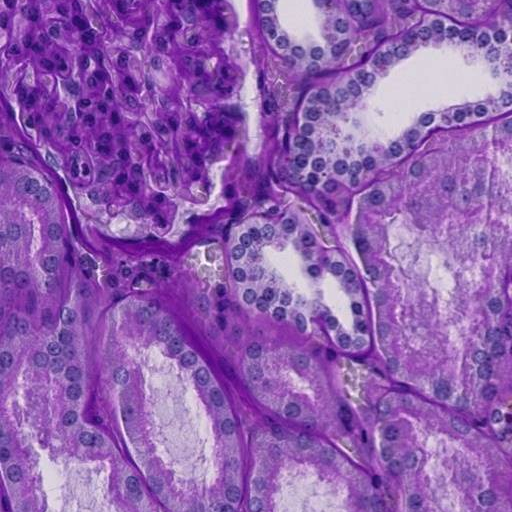

In [4]:
image

In [10]:
image = np.array(image).reshape(1,512,512,3)
y_pred = model.predict(image)

1/1 [==============================] - 2s 2s/step


In [11]:
y_pred.shape

(1, 512, 512, 1)

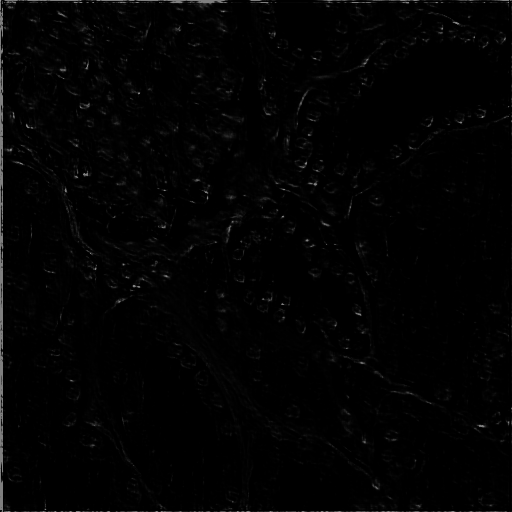

In [41]:
Image.fromarray((y_pred.reshape(512, 512) * 255).astype(np.uint8))

In [5]:
import os
from PIL import Image

non_segment_dir = 'train_image'
segment_dir = 'Image_Blood_Vessel'
image_size = (512, 512)

# Get a list of image filenames in the non-segmented folder
non_segment_files = os.listdir(non_segment_dir)

train_images = []
train_labels = []

# Load the images and labels
for filename in non_segment_files[:100]:
    image_path = os.path.join(non_segment_dir, filename)
    label_filename = f"{filename.split('.')[0]}.png"
    label_path = os.path.join(segment_dir, label_filename)

    # Load the non-segmented image
    image = Image.open(image_path)
    image = image.resize(image_size)
    image = np.array(image)
    train_images.append(image)

    # Load the corresponding segmented label
    label = Image.open(label_path)
    label = label.resize(image_size)
    label = np.array(label)
    train_labels.append(label)

# Perform any further processing or conversion if needed

# Convert the lists to NumPy arrays or use them directly for training
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shapes of the loaded images and labels
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)


Train Images Shape: (100, 512, 512, 3)
Train Labels Shape: (100, 512, 512)


In [6]:
train_labels = train_labels.reshape(100,512,512,1)

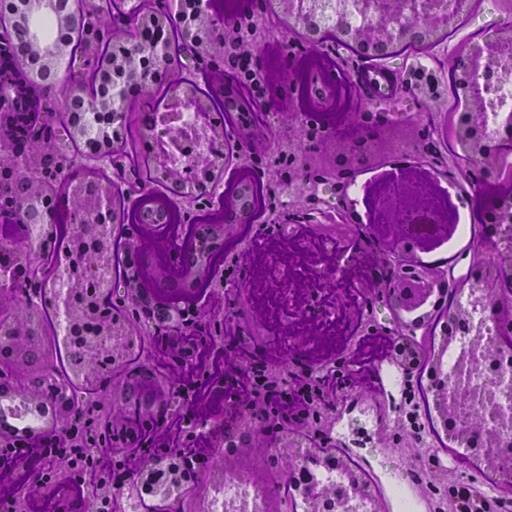

In [7]:
Image.fromarray(train_images[1].reshape(512,512,3).astype(np.uint8))

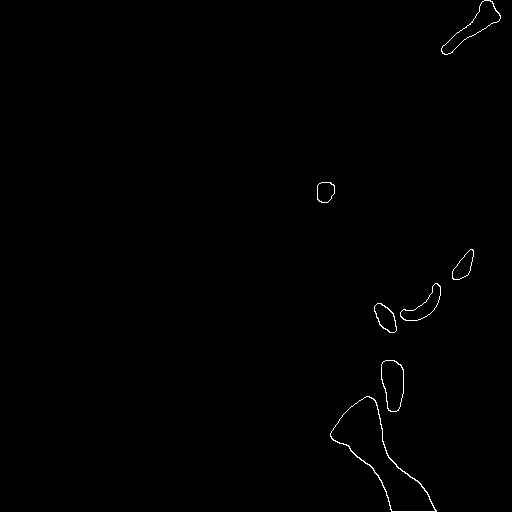

In [8]:
Image.fromarray(train_labels[1].reshape(512,512).astype(np.uint8))

In [9]:
import tensorflow as tf

def train(model, train_images, train_labels, num_epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0

        # Iterate over batches of images and labels
        for step in range(0, len(train_images), batch_size):
            batch_images = train_images[step:step+batch_size]
            batch_labels = train_labels[step:step+batch_size]

            # Forward pass
            with tf.GradientTape() as tape:
                predictions = model(batch_images)
                loss_value = loss_fn(batch_labels, predictions)
                total_loss += loss_value

            # Backward pass and optimization
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Compute average loss for the epoch
        average_loss = total_loss / (len(train_images) // batch_size)
        print(f"Epoch {epoch+1} loss: {average_loss}")

In [ ]:
# Example usage
model = unet_model(input_shape=(512, 512, 3))  # Create the U-Net model


num_epochs = 3
batch_size = 10

train(model, train_images, train_labels, num_epochs, batch_size)

2023-06-02 09:39:14.352607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-02 09:39:14.352655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (limsim-inspiron5584): /proc/driver/nvidia/version does not exist
2023-06-02 09:39:14.354418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3


2023-06-02 09:39:14.817301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2023-06-02 09:39:15.083034: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2023-06-02 09:39:15.384593: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2023-06-02 09:39:15.672106: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2023-06-02 09:39:16.386640: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.


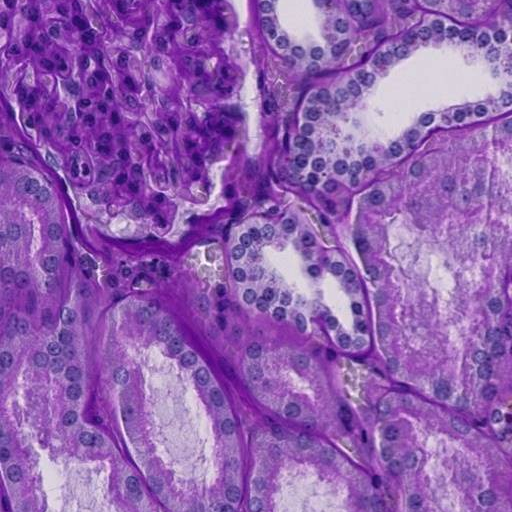

In [23]:
image = Image.open('train_image/0006ff2aa7cd.tif')
image

In [24]:
image = np.array(image).reshape(1,512,512,3)
y_pred = model.predict(image)

1/1 [==============================] - 2s 2s/step


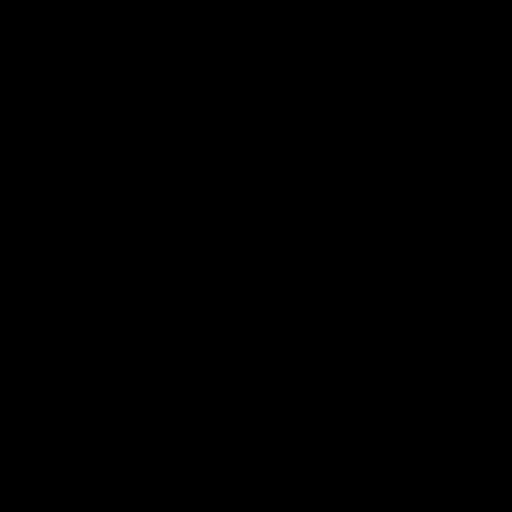

In [25]:
Image.fromarray((y_pred.reshape(512, 512)).astype(np.uint8))

In [26]:
y_pred.reshape(512, 512)

array([[0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331],
       [0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331],
       [0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331],
       ...,
       [0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331],
       [0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331],
       [0.5028331, 0.5028331, 0.5028331, ..., 0.5028331, 0.5028331,
        0.5028331]], dtype=float32)